In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind 

In [2]:
wine1 = pd.read_csv('data/winemag-data_first150k.csv')
wine2 = pd.read_csv('data/winemag-data-130k-v2.csv')

# Wine Reviews Data Exploration
## Data
This is the dataset I found on [Kaggle](https://www.kaggle.com/zynicide/wine-reviews), the original dataset was scraped from [WineEnthusiast](https://www.winemag.com/?s=&drink_type=wine). The collection of dataset was inspired by the movie [Somm](https://www.imdb.com/title/tt2204371/), which is a documentary movie that describes four sommeliers attempt to pass the Master Sommelier exam, a test with one of the lowest pass rates in the world.

The reason I chose this dataset for my exploration report is that I found wine tasting a pretty important social skills and the more knowledge you have regarding wines, people seems to show more interests and repects of you. This dataset consists of around 280K observations and I think this is a good start of my first capstone project for exploratory data analysis practice.

The dataset conssits of 2 tables, which were basically scraped in different times, both tables contain country, description, designation, points, price, province, regions, variety and winery. One of the table has more information about taster name, taster twitter handle and title of the wine review. 



## Analytic Questions
### 1. What are the type of grapes that are mostly used to make the wine in US? How about in each state?

First of all, we want to combine both two tables into one, since `wine2` table has more columns than `wine1`, we dropped the `taster`, `taster_twitter_handle` and `title` columns in order to match the number of columns in both table. Those three columns could be further analyze if we are interested in answering question like "Which taster tends to give higher score of wine that are from a certain country/winery?"

In [3]:
# drop taster, taster_twitter_handle and title columns from wine2 table
wine2_r1 = wine2.drop(['taster_name', 'taster_twitter_handle', 'title'], axis=1).copy()

In [4]:
# drop the first column 'Unnamed:0' from both table since those are only index
wine2_r2 = wine2_r1.drop(['Unnamed: 0'], axis=1)
wine1_r1 = wine1.drop(['Unnamed: 0'], axis=1).copy()

In [5]:
# combine both cleaned tables together
wine_all = wine1_r1.append(wine2_r2)
wine_all.shape

(280901, 10)

In [6]:
# first, we explore the compositions of the country column by percentage of data observations
wine_all['country'].value_counts(normalize=True).head()*100

US          41.626518
France      15.379603
Italy       15.318000
Spain        5.310273
Portugal     3.921548
Name: country, dtype: float64

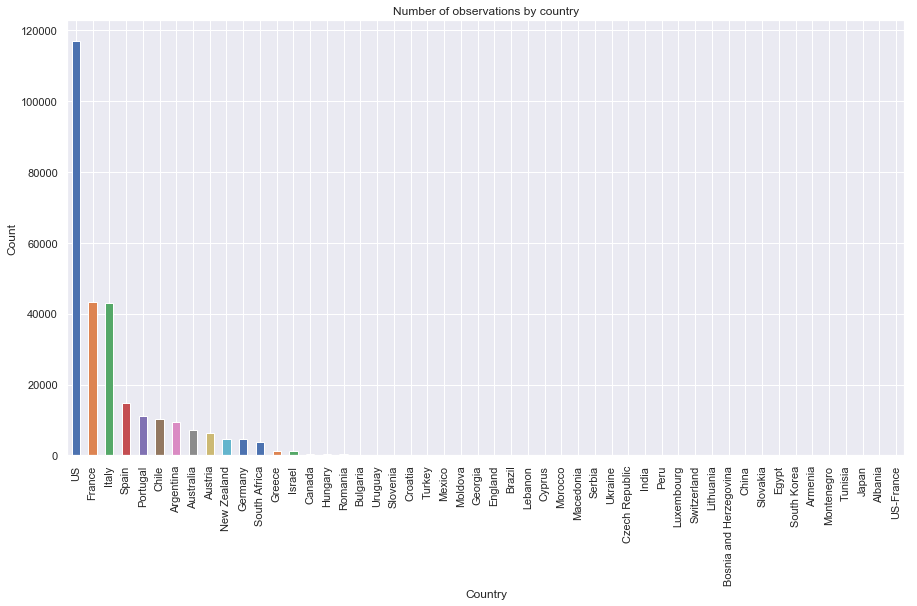

In [7]:
# second, explore the number of observations from each country
sns.set()
fig, ax = plt.subplots(figsize=(15,8))
ax = wine_all['country'].value_counts().plot(kind='bar', ax=ax)
ax.set(title='Number of observations by country', xlabel='Country', ylabel='Count')
plt.show()

From the table and the graph showing, we could see US has occupied around 41.6% data observation, which deserves a further analysis by itself.

In [8]:
# filtering out the wine that is produced in US
wine_us = wine_all[wine_all['country'] == 'US']
# see how many unique variety are there in the wine produced in US
wine_us['variety'].value_counts().shape

(274,)

Since there are 274 different varieties of grapes that are used in the wine in US, we are only interested in the top10 since there is a lot of variety that only has 1 or 2 observation

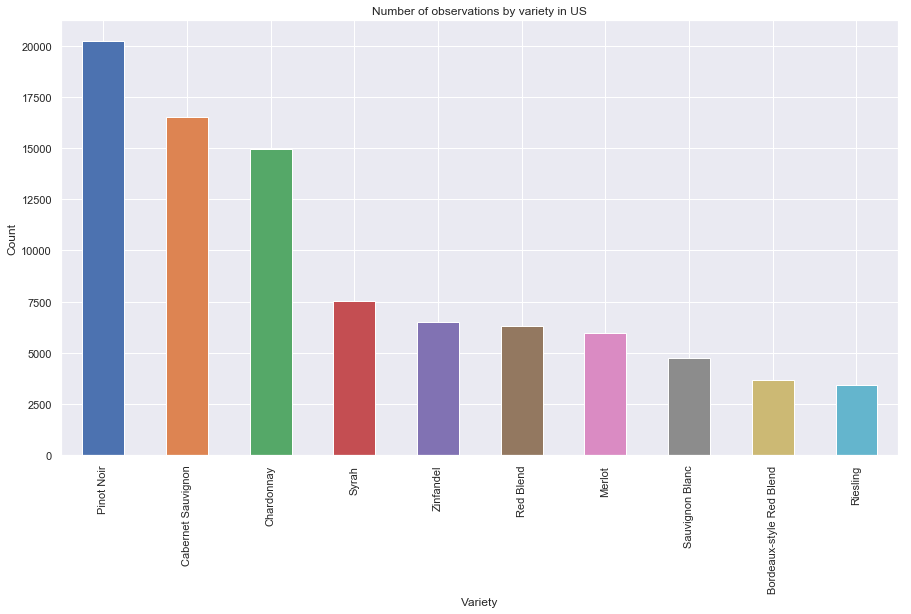

In [9]:
fig, ax = plt.subplots(figsize=(15,8))
ax = wine_us['variety'].value_counts().head(10).plot(kind='bar', ax=ax)
ax.set(title='Number of observations by variety in US', xlabel='Variety', ylabel='Count')
plt.show()

From the previous graph, we could tell the type of grapes that are used most in the US is Pinot Noir, which is a pretty common grape type for brewing wine. Let us further examine whether the composition of top5 variety in the whole country apply on each state as well. We first plot the bar plot again by state.

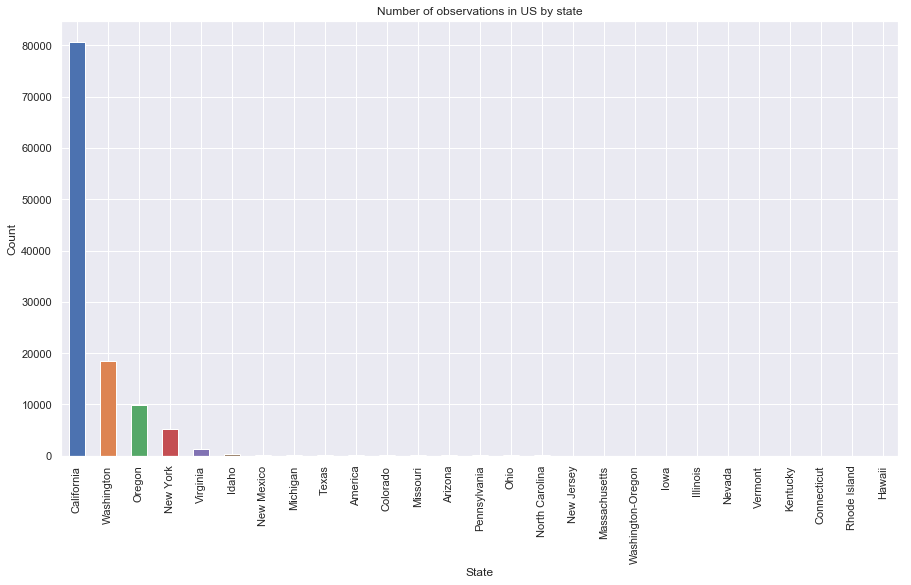

In [10]:
# plot the number of data observations for each state
fig, ax = plt.subplots(figsize=(15,8))
ax = wine_us['province'].value_counts().plot(kind='bar')
ax.set(title='Number of observations in US by state', xlabel='State', ylabel='Count')
plt.show()

From the graph showing above, we can tell most of the data observations in the US is actually from California, in fact, the top4 state account for more than 90% of the whole data. We could extract out top4 state and see whether the top variety of each state is the same as the whole country.

In [11]:
# extract the top4 states from the wine_us table
wine_us_ca = wine_us[wine_us['province'] == 'California']['variety'].value_counts().head()
wine_us_wa = wine_us[wine_us['province'] == 'Washington']['variety'].value_counts().head()
wine_us_or = wine_us[wine_us['province'] == 'Oregon']['variety'].value_counts().head()
wine_us_ny = wine_us[wine_us['province'] == 'New York']['variety'].value_counts().head()

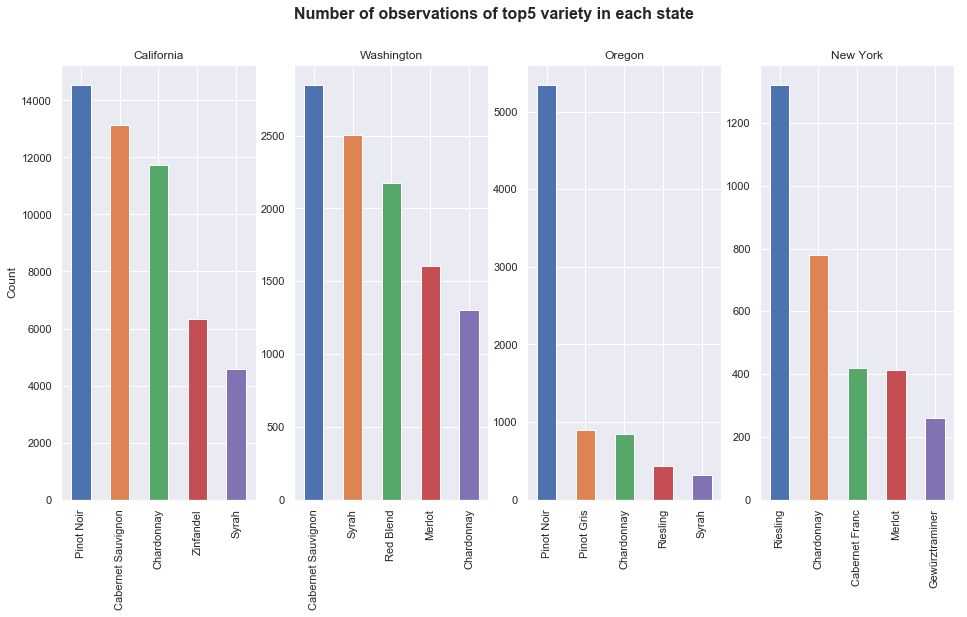

In [12]:
# plot the top5 variety for each state
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(16,8))
ax1 = wine_us_ca.plot(kind='bar', ax=ax1)
ax2 = wine_us_wa.plot(kind='bar', ax=ax2)
ax3 = wine_us_or.plot(kind='bar', ax=ax3)
ax4 = wine_us_ny.plot(kind='bar', ax=ax4)
ax1.set(title='California', ylabel='Count')
ax2.set(title='Washington')
ax3.set(title='Oregon')
ax4.set(title='New York')
fig.suptitle('Number of observations of top5 variety in each state', fontweight='bold', fontsize=16)
plt.show()

We can tell from the graph above, the composition of types of grapes in each state is pretty different, California and Oregon are dominated by Pinot Noir whereas New York is dominated by Riesling and Washington is dominated by Cabernet Sauvignon, these differences might be due to the local weather and soil, since different types of grapes may have different ideal conditions that could grow.

### 2. What are the relationship between points and price? Are the wines that have higher price generally have higher points as well? Is it possible to buy cheap but decent wine?

To answer this question, we first plot a simple scatter plot to see the relationship between these two variables.

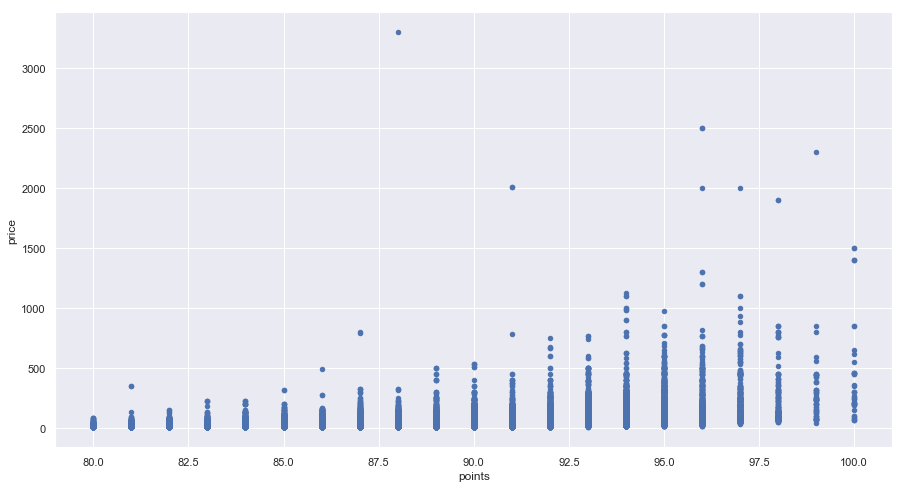

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax = wine_all.plot(kind='scatter', x='points', y='price', ax=ax)

From the graph showing above, it looks like the outliers (price > $500) is generally on the right side of the graph, which has higher points, but the ranges of price in a given point is pretty wide, except for the low-point group(points < 85), which has a lower price in general and the variance is not as much. Next we categorize the observations based on the price and see their points distribution using a boxplot, we will separte them into 6 groups: very low($15 or lower), low($15~$25), medium($25~$50), medium high($50~$100), high($100~$200), very high(more than $200), note that the lower bound is exclusive and the higher bound is inclusive.

In [14]:
# define a function that can categorize the price
def price_cat(price):
    result = np.where(price <= 15, 'very low', np.where(price>15 and price<=25, 'low', np.where(price>25 and price<=50, 
                      'medium', np.where(price>50 and price<=100, 'medium high', np.where(price>100 and price<=200,
                      'high', 'very high')))))
    return result
# vectorize the function to improve performance
price_cat_v = np.vectorize(price_cat)

In [15]:
# create a column "price_range" based on the price column using vectorized function price_cat_v
# alternative: use apply function wine_all['price_range'] = wine_all['price'].apply(price_cat)
wine_all['price_range'] = price_cat_v(wine_all['price'])
wine_all['price_range'].value_counts()

medium         82568
low            77456
very low       58995
medium high    32360
very high      24148
high            5374
Name: price_range, dtype: int64

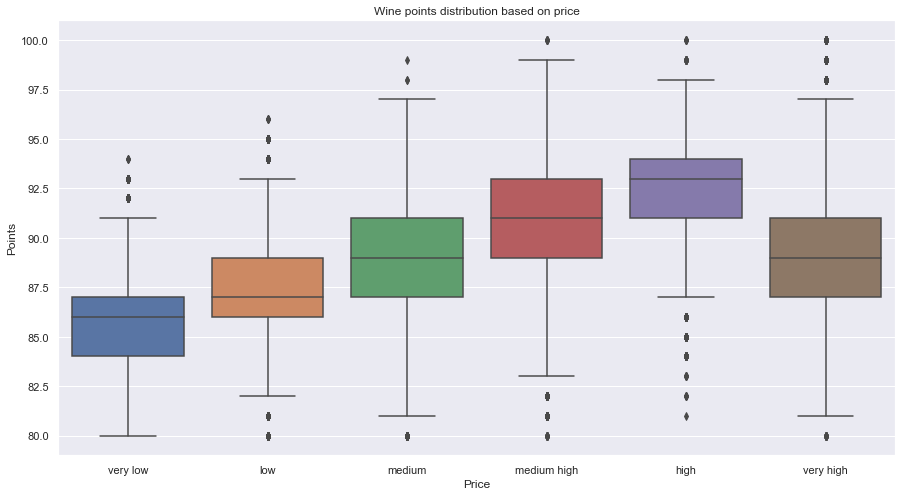

In [17]:
# make a boxplot by price_range category to show the points distribution of each range
order = ['very low', 'low', 'medium', 'medium high', 'high', 'very high']
fig, ax = plt.subplots(1,1, figsize=(15,8))
ax = sns.boxplot(x='price_range', y='points', data=wine_all, order=order)
ax.set(title='Wine points distribution based on price', xlabel='Price', ylabel='Points')
plt.show()

From the graph showing above, we can tell there is a general trend that the higher the price, the higher the points of the wine we get, though in the 'very high' price range(more than $200) group, the variance of points is pretty high and the medium is actually lower than the 'medium high' and 'high' group, if we trust the critics that higher points means higher quality of wine taste, from a customer perspective we probably do not want to spend too much money on a medium quality wine. It is also interesting to see some outliers showing in the very low and low group, this could mean a lot for customers like us, since we could get a cheap wine with a decent quality. We could further explore those outliers.

In [18]:
# explore the outliers in 'very low' and 'low' price group, setting the point threshold of 93 for 'very low' and 95
# for 'low' group based on the graph above
very_low = wine_all[(wine_all['price_range']=='very low') & (wine_all['points']>93)]
low = wine_all[(wine_all['price_range']=='low') & (wine_all['points']>95)]
very_low

,country,description,designation,points,price,province,region_1,region_2,variety,winery,price_range
140179,Spain,This reserve-level P.X. sets the gold standard...,Cardenal Cisneros Reservas,94,15.0,Andalucia,Jerez,NaN,Pedro Ximénez,Sanchez Romate,very low
19136,Spain,"A spectacularly sweet and rich bruiser, and on...",Pedro Ximenez 1827 Sweet Sherry,94,14.0,Andalucia,Jerez,NaN,Sherry,Osborne,very low
23974,Portugal,Assobio is from a single vineyard in the Quint...,Assobio,94,13.0,Douro,NaN,NaN,Portuguese Red,Quinta dos Murças,very low


In [19]:
low

,country,description,designation,points,price,province,region_1,region_2,variety,winery,price_range
56971,US,"Superb fruit highlights this tight, sculpted S...",NaN,96,20.0,Washington,Columbia Valley (WA),Columbia Valley,Syrah,Rulo,low
109231,US,"Superb fruit highlights this tight, sculpted S...",NaN,96,20.0,Washington,Columbia Valley (WA),Columbia Valley,Syrah,Rulo,low
134101,US,"Superb fruit highlights this tight, sculpted S...",NaN,96,20.0,Washington,Columbia Valley (WA),Columbia Valley,Syrah,Rulo,low
101580,US,"Superb fruit highlights this tight, sculpted S...",NaN,96,20.0,Washington,Columbia Valley (WA),Columbia Valley,Syrah,Rulo,low


As shown in the table above, we can see there are 7 candidates for us to choose from if we do not want to pay too much but still want a decent quality of wine we purchase.

### 3. US and France are the top two wine producers in the world, how are the quality compare in those two countries? 

First of all, we assume the quality of wine is based on the points variable. Besides, we need to compare the quality with the same type of grapes to make the game fair.

In [20]:
# extract the data observations for US and France
wine_us_fr = wine_all[wine_all['country'].isin(['US', 'France'])]

We then examine the top10 variety of grapes used in US and France to see if there are any overlaps to compare between the two

In [21]:
wine_us_fr[wine_us_fr['country']=='US']['variety'].value_counts().head(10)

Pinot Noir                  20225
Cabernet Sauvignon          16493
Chardonnay                  14928
Syrah                        7518
Zinfandel                    6500
Red Blend                    6324
Merlot                       5941
Sauvignon Blanc              4749
Bordeaux-style Red Blend     3656
Riesling                     3405
Name: variety, dtype: int64

In [22]:
wine_us_fr[wine_us_fr['country']=='France']['variety'].value_counts().head(10)

Bordeaux-style Red Blend      9685
Chardonnay                    5700
Pinot Noir                    4039
Rosé                          3265
Champagne Blend               2347
Bordeaux-style White Blend    2231
Sauvignon Blanc               1863
Rhône-style Red Blend         1607
Gamay                         1555
Riesling                      1219
Name: variety, dtype: int64

From the tables showing above, we could see some overlapping between the top10 in each country, we pick `Pinot Noir`, `Chardonnay` and `Sauvignon Blanc` for ous analysis to see which country has a better performance in each wine.

In [23]:
# further extract three grape variety in wine_us_fr table
wine_us_fr_grape = wine_us_fr[wine_us_fr['variety'].isin(['Pinot Noir', 'Chardonnay', 'Sauvignon Blanc'])]

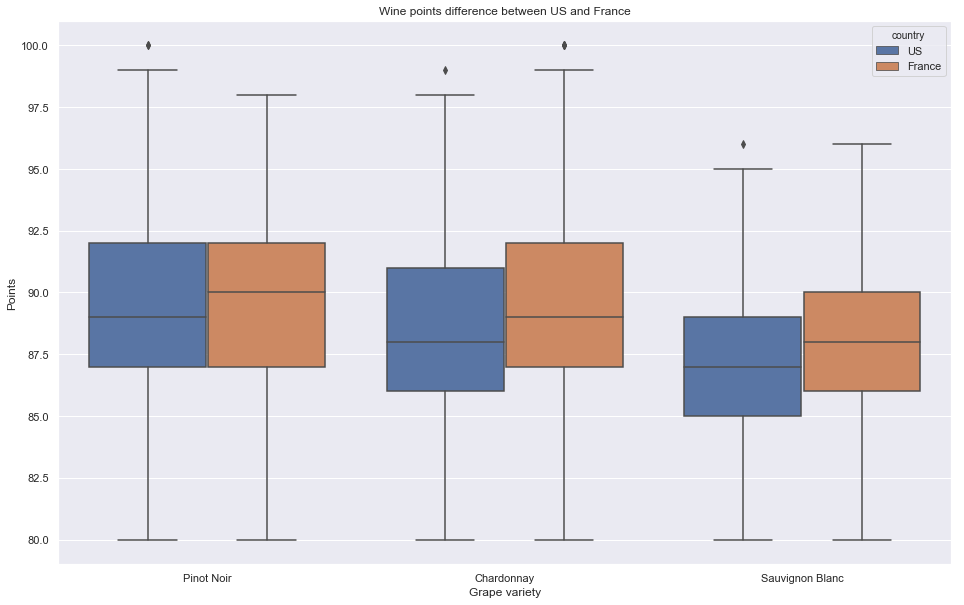

In [24]:
# make a boxplot to see the difference in quality(points) between countries and grape varieties
fig, ax = plt.subplots(1, 1, figsize=(16,10))
ax = sns.boxplot(x='variety', y='points', hue='country', ax=ax, order=['Pinot Noir', 'Chardonnay', 'Sauvignon Blanc'],
                data=wine_us_fr_grape)
ax.set(title='Wine points difference between US and France', xlabel='Grape variety', ylabel='Points')
plt.show()

We can see that in general, France has higher medium in all three grape variety category, the next step is to see whether this is statistical significant or not, we will perform t test for each grape variety category to compare the mean points difference between each country.

In [25]:
# we first extract each grape variety in each country
wine_us_pinot = wine_us_fr[(wine_us_fr['country']=='US')&(wine_us_fr['variety']=='Pinot Noir')]
wine_fr_pinot = wine_us_fr[(wine_us_fr['country']=='France')&(wine_us_fr['variety']=='Pinot Noir')]
wine_us_chard = wine_us_fr[(wine_us_fr['country']=='US')&(wine_us_fr['variety']=='Chardonnay')]
wine_fr_chard = wine_us_fr[(wine_us_fr['country']=='France')&(wine_us_fr['variety']=='Chardonnay')]
wine_us_sauv = wine_us_fr[(wine_us_fr['country']=='US')&(wine_us_fr['variety']=='Sauvignon Blanc')]
wine_fr_sauv = wine_us_fr[(wine_us_fr['country']=='France')&(wine_us_fr['variety']=='Sauvignon Blanc')]

In [26]:
# create a table that list the mean points in each group
points_us_fr = {'Pinot Noir': [wine_us_pinot.points.mean(), wine_fr_pinot.points.mean()],
                'Chardonnay': [wine_us_chard.points.mean(), wine_fr_chard.points.mean()],
                'Sauvignon Blanc': [wine_us_sauv.points.mean(), wine_fr_sauv.points.mean()]}
wine_compare = pd.DataFrame(points_us_fr, index=['US', 'France'])
wine_compare

,Pinot Noir,Chardonnay,Sauvignon Blanc
US,89.234363,88.054863,87.098758
France,89.588264,89.288596,88.192700


In [27]:
# perfrom t-test on Pinot Noir group
print(ttest_ind(wine_us_pinot['points'], wine_fr_pinot['points'], equal_var=False))

Ttest_indResult(statistic=-6.5238590893106965, pvalue=7.421932004515324e-11)


In [28]:
# perfrom t-test on Chardonnay group
print(ttest_ind(wine_us_chard['points'], wine_fr_chard['points'], equal_var=False))

Ttest_indResult(statistic=-24.797053133683615, pvalue=4.700062193968444e-132)


In [29]:
# perfrom t-test on Sauvignon Blanc group
print(ttest_ind(wine_us_sauv['points'], wine_fr_sauv['points'], equal_var=False))

Ttest_indResult(statistic=-14.404083097935084, pvalue=1.0707122567101302e-45)


From those three t-test, we can see that the p-value are all pretty low, almost close to zero, since from the previous table we can tell all three types of grape varieties in the US have average points lower than in the France. The close-to-zero p-value further prove that this observation is indeed statistically significant. We can couclude that France in general has better quality of wine produced in these three grape varieties.